In [1]:
# (필수) 아키텍처 유형(1,2,3) 중에서 하나를 골라 지정해야 합니다. 지정한 유형과 구현결과가 일치하지 않으면 "기타그룹"으로 간주함.
DNN_TYPE = 3

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.6.4


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans  
from sklearn import set_config
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import re
import random

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import set_config
import random

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

2.6.4


In [4]:
SEED=122

In [5]:
X_train, y_train, X_test, test_id = pd.read_pickle('/kaggle/input/kml2022f-exam/exam_data.pkl')

print(X_train.shape, X_test.shape)

(16570, 11) (11048, 11)


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

In [8]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(SEED)
    random.seed(SEED)
    tf.compat.v1.set_random_seed(SEED)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [9]:
inputs = keras.Input(shape=X_train.shape[1],)

y = keras.layers.BatchNormalization()(inputs)

x = keras.layers.Dense(32, activation='elu')(inputs)
x = keras.layers.Dense(11, activation='elu')(x)

x = keras.layers.Add()([x, y])

z = keras.layers.Dense(32, activation='elu')(x)
z = keras.layers.Dense(11, activation='elu')(z)

x = keras.layers.Add()([x, z])
outputs = keras.layers.Dense(1, activation='elu')(x)

model = keras.Model(inputs, outputs)

2022-12-16 06:17:28.163776: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


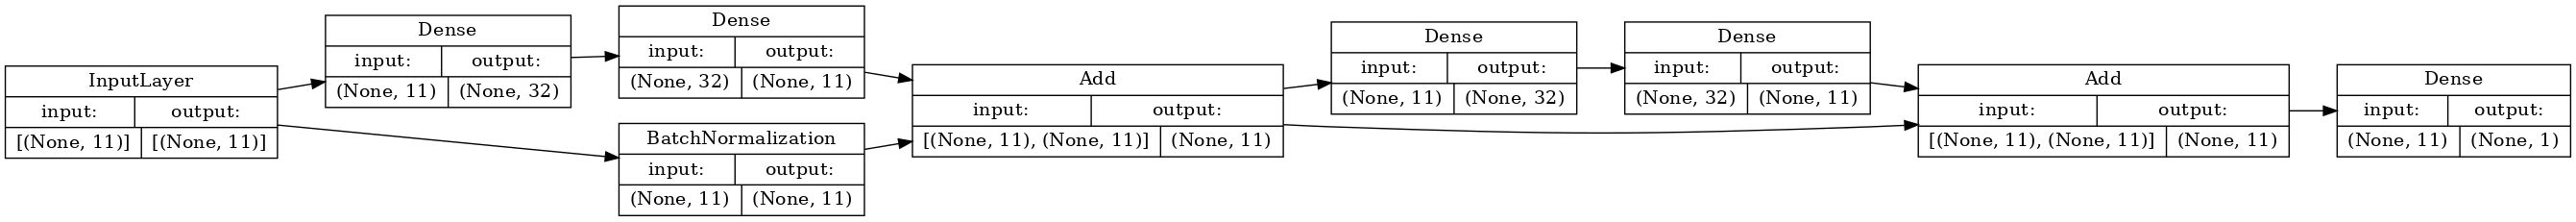

In [10]:
# (필수) 모델 정의를 한 후 반드시 아래 코드를 그대로 실행하여 선택한 아키텍처가 제대로 구현되었는지 보여주어야 합니다!!!
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=100, rankdir='LR')

In [11]:
def model_fn(hp):
    model = keras.Model(inputs, outputs)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.05, 0.03, 0.01, 0.005, 0.001, 0.0005])), 
                  metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [12]:
# Tuner 설정
tuner = kt.Hyperband(model_fn,
                     objective=kt.Objective('val_rmse', direction="min"), 
                     max_epochs=100,
                     hyperband_iterations=2,
                     overwrite=True,
                     directory='dnn_tuning')

In [13]:
%%time

# 최적화 수행
tuner.search(X_train, y_train, 
             validation_data=(X_valid, y_valid), 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)], verbose=0)

2022-12-16 06:17:30.034272: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 19.7 s, sys: 2.25 s, total: 21.9 s
Wall time: 20.1 s


In [14]:
# 베스트 모델 사용
model = tuner.get_best_models(1)[0]
# submission 화일명에 사용
val_rmse = model.evaluate(X_valid, y_valid, verbose=0)[1]

In [15]:
tuner.results_summary(num_trials=1)

Results summary
Results in dnn_tuning/untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0005
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 843.7693481445312


In [16]:
# 전체 데이터로 재학습
hist = model.fit(
    x=np.concatenate((X_train, X_valid)),
    y=np.concatenate((y_train, y_valid)),
    batch_size=32, 
    epochs=16,         # 작은값으로 설정
    shuffle=False,      
    verbose=2,
)

Epoch 1/16
518/518 - 2s - loss: 669177.1875 - rmse: 818.0325
Epoch 2/16
518/518 - 1s - loss: 668072.7500 - rmse: 817.3572
Epoch 3/16
518/518 - 1s - loss: 667421.5000 - rmse: 816.9587
Epoch 4/16
518/518 - 1s - loss: 666870.4375 - rmse: 816.6213
Epoch 5/16
518/518 - 1s - loss: 666368.0625 - rmse: 816.3137
Epoch 6/16
518/518 - 1s - loss: 665894.0625 - rmse: 816.0233
Epoch 7/16
518/518 - 1s - loss: 665442.3125 - rmse: 815.7465
Epoch 8/16
518/518 - 1s - loss: 665009.1250 - rmse: 815.4809
Epoch 9/16
518/518 - 1s - loss: 664600.7500 - rmse: 815.2305
Epoch 10/16
518/518 - 1s - loss: 664204.9375 - rmse: 814.9877
Epoch 11/16
518/518 - 1s - loss: 663822.6250 - rmse: 814.7531
Epoch 12/16
518/518 - 1s - loss: 663448.7500 - rmse: 814.5236
Epoch 13/16
518/518 - 1s - loss: 663093.8750 - rmse: 814.3058
Epoch 14/16
518/518 - 1s - loss: 662744.5625 - rmse: 814.0912
Epoch 15/16
518/518 - 1s - loss: 662411.7500 - rmse: 813.8868
Epoch 16/16
518/518 - 1s - loss: 662082.0000 - rmse: 813.6842


In [17]:
# 예측값 얻기: sklearn 과 달리 2차원 array로 출력 => 1차원으로 변경 필요.
pred = model.predict(X_test).flatten()

# submission 화일 생성
filename = 'submission.csv'
pd.DataFrame({'ID':test_id, 'Salary':pred}).to_csv(filename, index=False)

print(f'{filename} is ready to submit.')

submission.csv is ready to submit.


In [18]:
pred

array([2356.1196, 3930.4136, 5249.3135, ..., 2622.6099, 1579.7698,
       2016.2439], dtype=float32)

In [19]:
#814